In [1]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools
%load_ext autoreload
%autoreload 2


# Dynamic Optimization Problem: Dentists

We start of by defining a set of parameters and then build our cost function that our agent is facing when deciding on going to the dentist or not. Initially, there is only one state variable, usage of teeth (x), the agent starts with 0. Later, we add age as an additional state variable. 

There is a fix cost associated with going to the dentist. Say making an appointment, taking your time to go there etc. 
Furthermore, there is a marginal cost, depending on x. If you have very bad teeth (large x), then the cost of treatment should also be higher. Say you need a more complicated procedure, some root fills etc. 

Apart from costs, there is also pain associated with letting your teeth decay. Both costs and pain go into our total utility function. 

The transition of x into the next time period, depends on the decision (d), if the agent went to the dentist or not. 
If the agent postpones her check ups the total cost will increase. The agent maximizes the total discounted utility. 

$\textbf{Disclaimer!}$ Note that we are optimizing by brute force and advise not to solve the model for a life span over 15 years. As it served our imagination, we think of the agent as a dog, making the life span more realistic. The owner takes the decisions fully alturisticlly and feels the ache as it starts barking more. 

## Set base parameters and functions

In [2]:
par = SimpleNamespace()
par.x_t = 0 #x being the current level of usage of your teeth
par.FC = 10 #Fixed cost of going to the dentist
par.MC = 2 #Marginal cost of going to the dentist, depends on your usage of the teeth (when you last went)
par.beta = 0.8 #Discount factor
par.exponent = 1.2 #How bad your teeth decay if you don't see a dentist
par.gamma = 3
par.boost = 10 #How much your dental health increases by going to the dentist
par.x_start = 0
par.life_span = 13
par.natural_punishment = 3 #Of not going to the dentist. 

In [3]:
def cost_dentist(par, d, x_t):
    if d == 0: 
        return  0 #Implies that one is not going to the dentist and that this cost is 0
    if d == 1: 
        return par.FC + par.MC*x_t # Implies that one is going to the dentist where the cost depends on the fixed cost, marginal cost and current level of usage of ones teeth    

In [4]:
def teeth_decay(par, d, x_t, age, extension = False): #How your teeth are transitioning from one time period to the next
    if extension == True: 
        if d == 0: #Implies that one is not going to the dentist
            x_1 = (age/4)*x_t**par.exponent + par.natural_punishment + age  #We have to avoid that the teeth decay too small is zero for low values of x
        else:
            x_1 = max(x_t - par.boost + age, age) #Implies that one is going to the dentist
    else: 
        if d == 0: #Implies that one is not going to the dentist
            x_1 = x_t**par.exponent + par.natural_punishment  #We have to avoid that the teeth decay too small is zero for low values of x
        else:
            x_1 = max(x_t - par.boost, 0) #Implies that one is going to the dentist
        
    return x_1

In [5]:
def disutil_ache(par, x_t): 
    disutil = np.sqrt(x_t) * par.gamma + x_t #Disutility of toothache increases with current level of usage of your teeth and some constant (gamma)
    return disutil


In [6]:
def total_util(par, d, x_t):
    return -cost_dentist(par, d, x_t) - disutil_ache(par, x_t)
#The function calculates the total utility by subtracting the cost of the dentist visit and the disutility associated with toothache.

In [7]:
def n_combinations(t):
    digits = (0, 1)
    return list(itertools.product(digits, repeat=t-1))

#Possible paths of the decision tree with one binary decision. 

## Plotting the functions

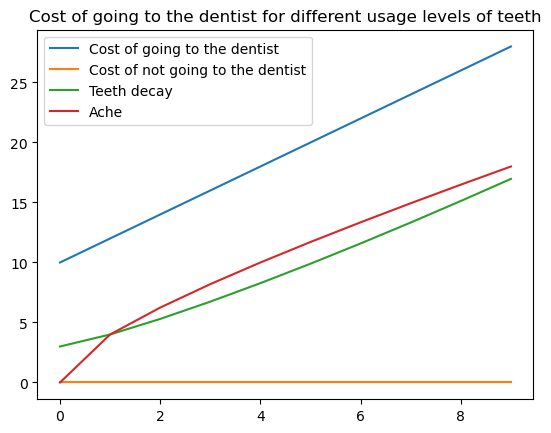

In [8]:
#Empty lists are initilized 
c_going = []
c_not_going = []
expo = []
logo = []
ache = []
decay = []

#looping: iterating over the range from 0 to 9. In each iteration, the code appends values to the lists using the corresponding functions:
for i in range(0,10):
    c_going.append(cost_dentist(par,1, i))
    c_not_going.append(cost_dentist(par,0, i))
    decay.append(teeth_decay(par, d=0, x_t= i, age=0, extension=False))
    ache.append(disutil_ache(par, i))

#Plotting
plt.plot(c_going, label='Cost of going to the dentist')
plt.plot(c_not_going, label='Cost of not going to the dentist')
plt.plot(decay, label='Teeth decay')
plt.plot(ache, label='Ache')
plt.title('Cost of going to the dentist for different usage levels of teeth')
plt.legend()
plt.show()


In the graph below, total utility of not going will always be higher, as no costs are included only the pain. 

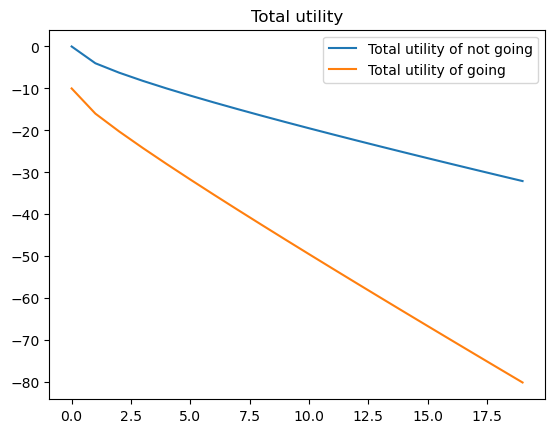

In [9]:
#Empthy lists are initialized for the case when going and not going to the dentist
tot_util_go = []
tot_util_no = []

#looping: iterating over the range from 0 to 19. In each iteration, the code appends values to the lists using the corresponding functions:
for i in range(0,20):
    tot_util_go.append(total_util(par, d = 1 , x_t= i))
    tot_util_no.append(total_util(par, d = 0 , x_t = i))

#Plotting
plt.plot(tot_util_no, label='Total utility of not going')
plt.plot(tot_util_go, label='Total utility of going')
plt.title('Total utility')
plt.legend()
plt.show()

## Solving the dentist problem
In essence, we solve the model by brute force. We calculate possible combinations of decisions, hence every path of the decision tree. Knowing that the agent will not go to the dentist in the last time period but only will feel the ache of the choosen level of x. 

In [10]:
#Initialise
par.life_span = 13
par.beta = 0.99


def solve_dentist(par, extension = False):
    possible_paths = n_combinations(par.life_span) #Create all decision combinations, excluding the last time period (d==0)
    n_paths = len(possible_paths) #Game starts in t1 with a t0 value. 
    x = np.zeros((n_paths, par.life_span)) #decay_path_matrix
    x[:,0] = par.x_start #Change the first column, hence the starting value
    v = np.zeros((n_paths,par.life_span+1))#value_matrix
    
    age = 0
    #Loop through all paths
    for index, val in enumerate(possible_paths):
        #print('Decision path: ', index,val)
        age = 0
        for t, d in enumerate(val): 
            age += 1
            x_next = teeth_decay(par, d=d, x_t=x[index,t], age=age, extension= extension) #Transitioning from one time period to the next
            x[index, (t+1)] = x_next
            v[index, (t+1)] = (par.beta**t)*total_util(par, d=d, x_t=x[index, t])
            #print('Dental usage in period', t, ' = ', x[index, t])
        v[index, -1] = (par.beta**(par.life_span+1))*total_util(par, d=0, x_t=x[index, -1])
        best_path = v.sum(axis=1).argmax() #The decision path maximizing total utility 
        best_decisions = possible_paths[best_path]

    return best_decisions, x[best_path] #Return results: decision path to choose and how the teeth decay

## Presenting our results

### Initial model
Here we note that as the agent becomes more forward looking, the visits to the dentist happend more frequently in order to avoid paying a larger amount in the future (higher beta).
Note that the most forward looking agent would experience virtually no teeth decay and die with almost perfect teeth. 

In [11]:
#Sensitivity analysis by varying the beta parameter 
beta_values = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Initializing empty lists to store the results obtained in the following iteration.
teeth_decay_results = []
best_decisions_results = []

#looping: Iterates over each beta value 
for beta in beta_values:
    par.beta = beta
    best_decisions, teeth_decay_values = solve_dentist(par, extension=False)
    print('Best decisions for beta = ', beta, '\n', "Decisions: ",best_decisions, '\n', 
    "Teeth decay:",teeth_decay_values, '\n')

Best decisions for beta =  0.4 
 Decisions:  (0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0) 
 Teeth decay: [  0.           3.           6.73719282   0.           3.
   6.73719282   0.           3.           6.73719282  12.86676472
  24.44683604  49.33052183 110.58181118] 

Best decisions for beta =  0.5 
 Decisions:  (0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0) 
 Teeth decay: [ 0.          3.          6.73719282  0.          3.          6.73719282
  0.          3.          6.73719282  0.          3.          6.73719282
 12.86676472] 

Best decisions for beta =  0.6 
 Decisions:  (0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0) 
 Teeth decay: [0.         3.         0.         3.         0.         3.
 0.         3.         0.         3.         0.         3.
 6.73719282] 

Best decisions for beta =  0.7 
 Decisions:  (0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0) 
 Teeth decay: [0.         3.         0.         3.         0.         3.
 0.         3.         0.         3.         0.         3.
 6.73719282] 

Best decisions fo

## Extension one: Age
We wanted to make the teeth decay dependent on age and thus added an extension argument to the decay function. If the agent does not go to the dentist, there $ \frac{age}{4} $ is being multiplied with the initial function and age is also added to the same function. If one ignores the dentist age has an additive and a multiplicative effect.
If the agent does go, it only has an additive effect. Ensuring that teeth get somewhat worse over the life span. 

Note that here even the least forward looking agent would go to the dentist more often if teeth decay gets worse with age. 

In [12]:
#Sensitivity analysis by varying the beta parameter (Extended version)
beta_values = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for beta in beta_values:
    par.beta = beta
    best_decisions, teeth_decay_values = solve_dentist(par, extension=True)
    print('Best decisions for beta = ', beta, '\n', "Decisions: ",best_decisions, '\n', 
    "Teeth decay:",teeth_decay_values, '\n')

Best decisions for beta =  0.4 
 Decisions:  (0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0) 
 Teeth decay: [ 0.          4.          7.63901582 14.60411398  8.60411398  5.
  6.          7.          8.          9.         10.         11.
 68.30801078] 

Best decisions for beta =  0.5 
 Decisions:  (0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0) 
 Teeth decay: [ 0.          4.          7.63901582  3.         10.73719282  5.73719282
  6.          7.          8.          9.         10.         11.
 68.30801078] 

Best decisions for beta =  0.6 
 Decisions:  (0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0) 
 Teeth decay: [ 0.          4.          7.63901582  3.         10.73719282  5.73719282
  6.          7.          8.          9.         10.         11.
 68.30801078] 

Best decisions for beta =  0.7 
 Decisions:  (0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0) 
 Teeth decay: [ 0.          4.          7.63901582  3.          4.          5.
  6.          7.          8.          9.         10.         11.
 68.30801078] 

Best decisio

### Plotting the teeth decay with age. 
Here we see that the more impatient let their teeth decay more both when young and when close to death. 

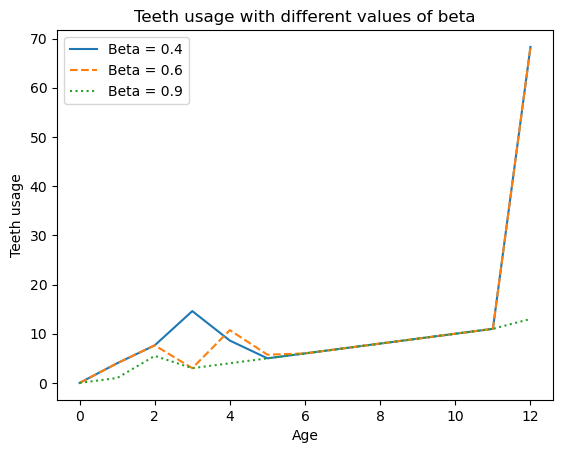

In [13]:
beta_values = [0.4, 0.6, 0.9]
linestyles = ['-', '--', ':']
for i, beta in enumerate(beta_values):
    par.beta = beta
    best_decisions, teeth_decay_values = solve_dentist(par, extension=True)
    label = f"Beta = {str(beta)}"
    plt.plot(teeth_decay_values, label=label, linestyle=linestyles[i])
plt.legend()
plt.title('Teeth usage with different values of beta')
plt.ylabel('Teeth usage')
plt.xlabel('Age')
plt.show()


## Extension 2: Subsidy 
Say we are a benevolant state and we want agents to have better teeth over their life span. We ask ourselves, whether it is more effective to subsidize the fixed cost or the marginal cost. Our budget is 1.5 dodge coins. We note that for a very impatient person, the fixed cost subsidy is more appropriate, as it incentivizes going to the dentist earlier, here the third time period. 

In [14]:
#Reset parameters
par.MC = 2 
par.FC = 10

In [15]:
#Solve both versions and store the results
par.beta=0.4
subsidy = 1.5

#Marginal cost
par.MC-=subsidy #Deduct subsidy from cost
decision_MC, decay_MC = solve_dentist(par=par, extension=True)

#Fixed cost
par.FC-=subsidy
decision_FC, decay_FC = solve_dentist(par=par, extension=True)

print('Marginal cost subsidy:  \n Decision path', decision_MC,'\n', 'Total usage over life span = ', sum(decay_MC), '\n')
print('Fixed cost subsidy:  \n Decision path', decision_FC,'\n', 'Total usage over life span = ', sum(decay_FC), '\n')


Marginal cost subsidy:  
 Decision path (0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0) 
 Total usage over life span =  159.15525456203622 

Fixed cost subsidy:  
 Decision path (0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0) 
 Total usage over life span =  150.42141224391077 

